In [1]:
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
import re
import os
from IPython.display import Image 
import cv2
from tempfile import TemporaryFile
from scipy import stats
from torchvision import transforms
import pandas as pd
import seaborn as sns
import shutil
import datetime
import glob
from scipy import integrate
from sklearn.decomposition import PCA
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import ImageFile, Image
import sys
sys.path.insert(1, '../architecture')
sys.path.insert(2, '../dataLoaders')
from ProUNet import *
import torchvision.models as models
from MapillaryDataLoader import *
# from VolvoDataLoader import *
from volvoDataLoader_onFly import *
from tqdm import tqdm
from torchsummary import summary
from matplotlib.patches import Rectangle
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE

import numpy as np
import cv2 as cv
#from MapRSCD import *
%matplotlib inline

2024-03-31 18:00:32.718691: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
transform_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4191, 0.4586, 0.4700], [0.2553, 0.2675, 0.2945]),
    transforms.Resize((256,256))
])

transform_ou = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.2553, 1/0.2675, 1/0.2945 ]),
                                transforms.Normalize(mean = [ -0.4191, -0.4586, -0.4700 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [3]:
args = {
    "mode":"train",
    "input_img_dim":(256,256),
    "mapillaryRootPath":'../../../datasets/augmented_mapillary',
    "cityscapesRootPath":'../../../datasets/augmented_cityscapes',
    "RSCDRootPath":'../../../datasets/RSCD',
    "volvoRootPath":"../../../datasets/VolvoAnnotatedImages/rawDataset/images",
    "reducedCategories":True
}

dataloader = volvo_onFly(**args)

In [5]:
device = torch.device('cuda:1')
model = ProUNet(gecoConfig = {"enable":False}, device = device, num_classes = dataloader.get_num_classes(), LatentVarSize = 6, beta = 3, training = True, num_samples = 16).to(device)
# check = torch.load("../checkpoints/HVAEFri_Segfri2/best.pth", map_location=device)
check = torch.load("../checkpoints/HVAEFri_volvo_onTheFly_crf3/best.pth", map_location=device)
model.load_state_dict(check['model_state_dict'])

<All keys matched successfully>

In [6]:
imgIdx = 540
    
frame = dataloader[imgIdx]
segs, dists, _ = model.inference(frame["image"].to(device).unsqueeze(0))
pca = PCA(n_components = 3)
flattenFeatures = []
for i in range(1000):
    flattenFeatures.append(torch.flatten(dists["dist1"].sample(), start_dim = 1, end_dim = 3).cpu().numpy()) 
pca.fit(np.array(flattenFeatures).squeeze(1))
        
        
sampled  = []
flattenFeatures = []
for i in range(1000):
    flattenFeatures.append(torch.flatten(dists["dist1"].sample(), start_dim = 1, end_dim = 3).cpu().numpy())
sampled.append(pca.transform(np.array(flattenFeatures).squeeze(1)))        
sampled = np.array(sampled).squeeze(0)
sampledDF = pd.DataFrame(sampled, columns=["Latent variable 1", "Latent variable 2", "z"])

/home/lunet/wsmo6/.conda/envs/3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
sample = dists["dist1"].sample()

In [8]:
flattenFeatures = torch.flatten(sample, start_dim = 1, end_dim = 3).cpu().numpy()
sample_transformed = pca.transform(flattenFeatures)
sample_transformed_modified = sample_transformed + 1
sample_modified = torch.tensor(pca.inverse_transform(sample_transformed_modified).reshape(1,6,16,16)).to(device)

In [9]:
# fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20))
# ax[0][0].grid(False)
# ax[0][1].grid(False)
# ax[1][0].grid(False)
# ax[1][1].grid(False)



# ax[0][0].imshow(frame["image"].cpu().permute(1, 2, 0))
# ax[0][0].set_title("Input image", fontsize=17)

# ax[0][1].imshow(frame["seg"].permute(1, 2, 0))
# ax[0][1].set_title("Ground Truth", fontsize=17)

# ax[1][0].imshow(invTrans(frame["image"].cpu()).permute(1, 2, 0))
# ax[1][0].set_title("Input image", fontsize=17)

# sns.kdeplot(data=sampledDF, x="Latent variable 1", y="Latent variable 2", ax = ax[1][1], fill = True)
# sns.set(rc={"figure.figsize":(20, 20)})
# ax[1][1].plot(sample_transformed[0][0], sample_transformed[0][1], "ro", label = "Org latent code")
# ax[1][1].plot(sample_transformed_modified[0][0], sample_transformed_modified[0][1], "yo", label = "Modified latent code")
# ax[1][1].set_aspect(1)


# fig.tight_layout()
# plt.legend()
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


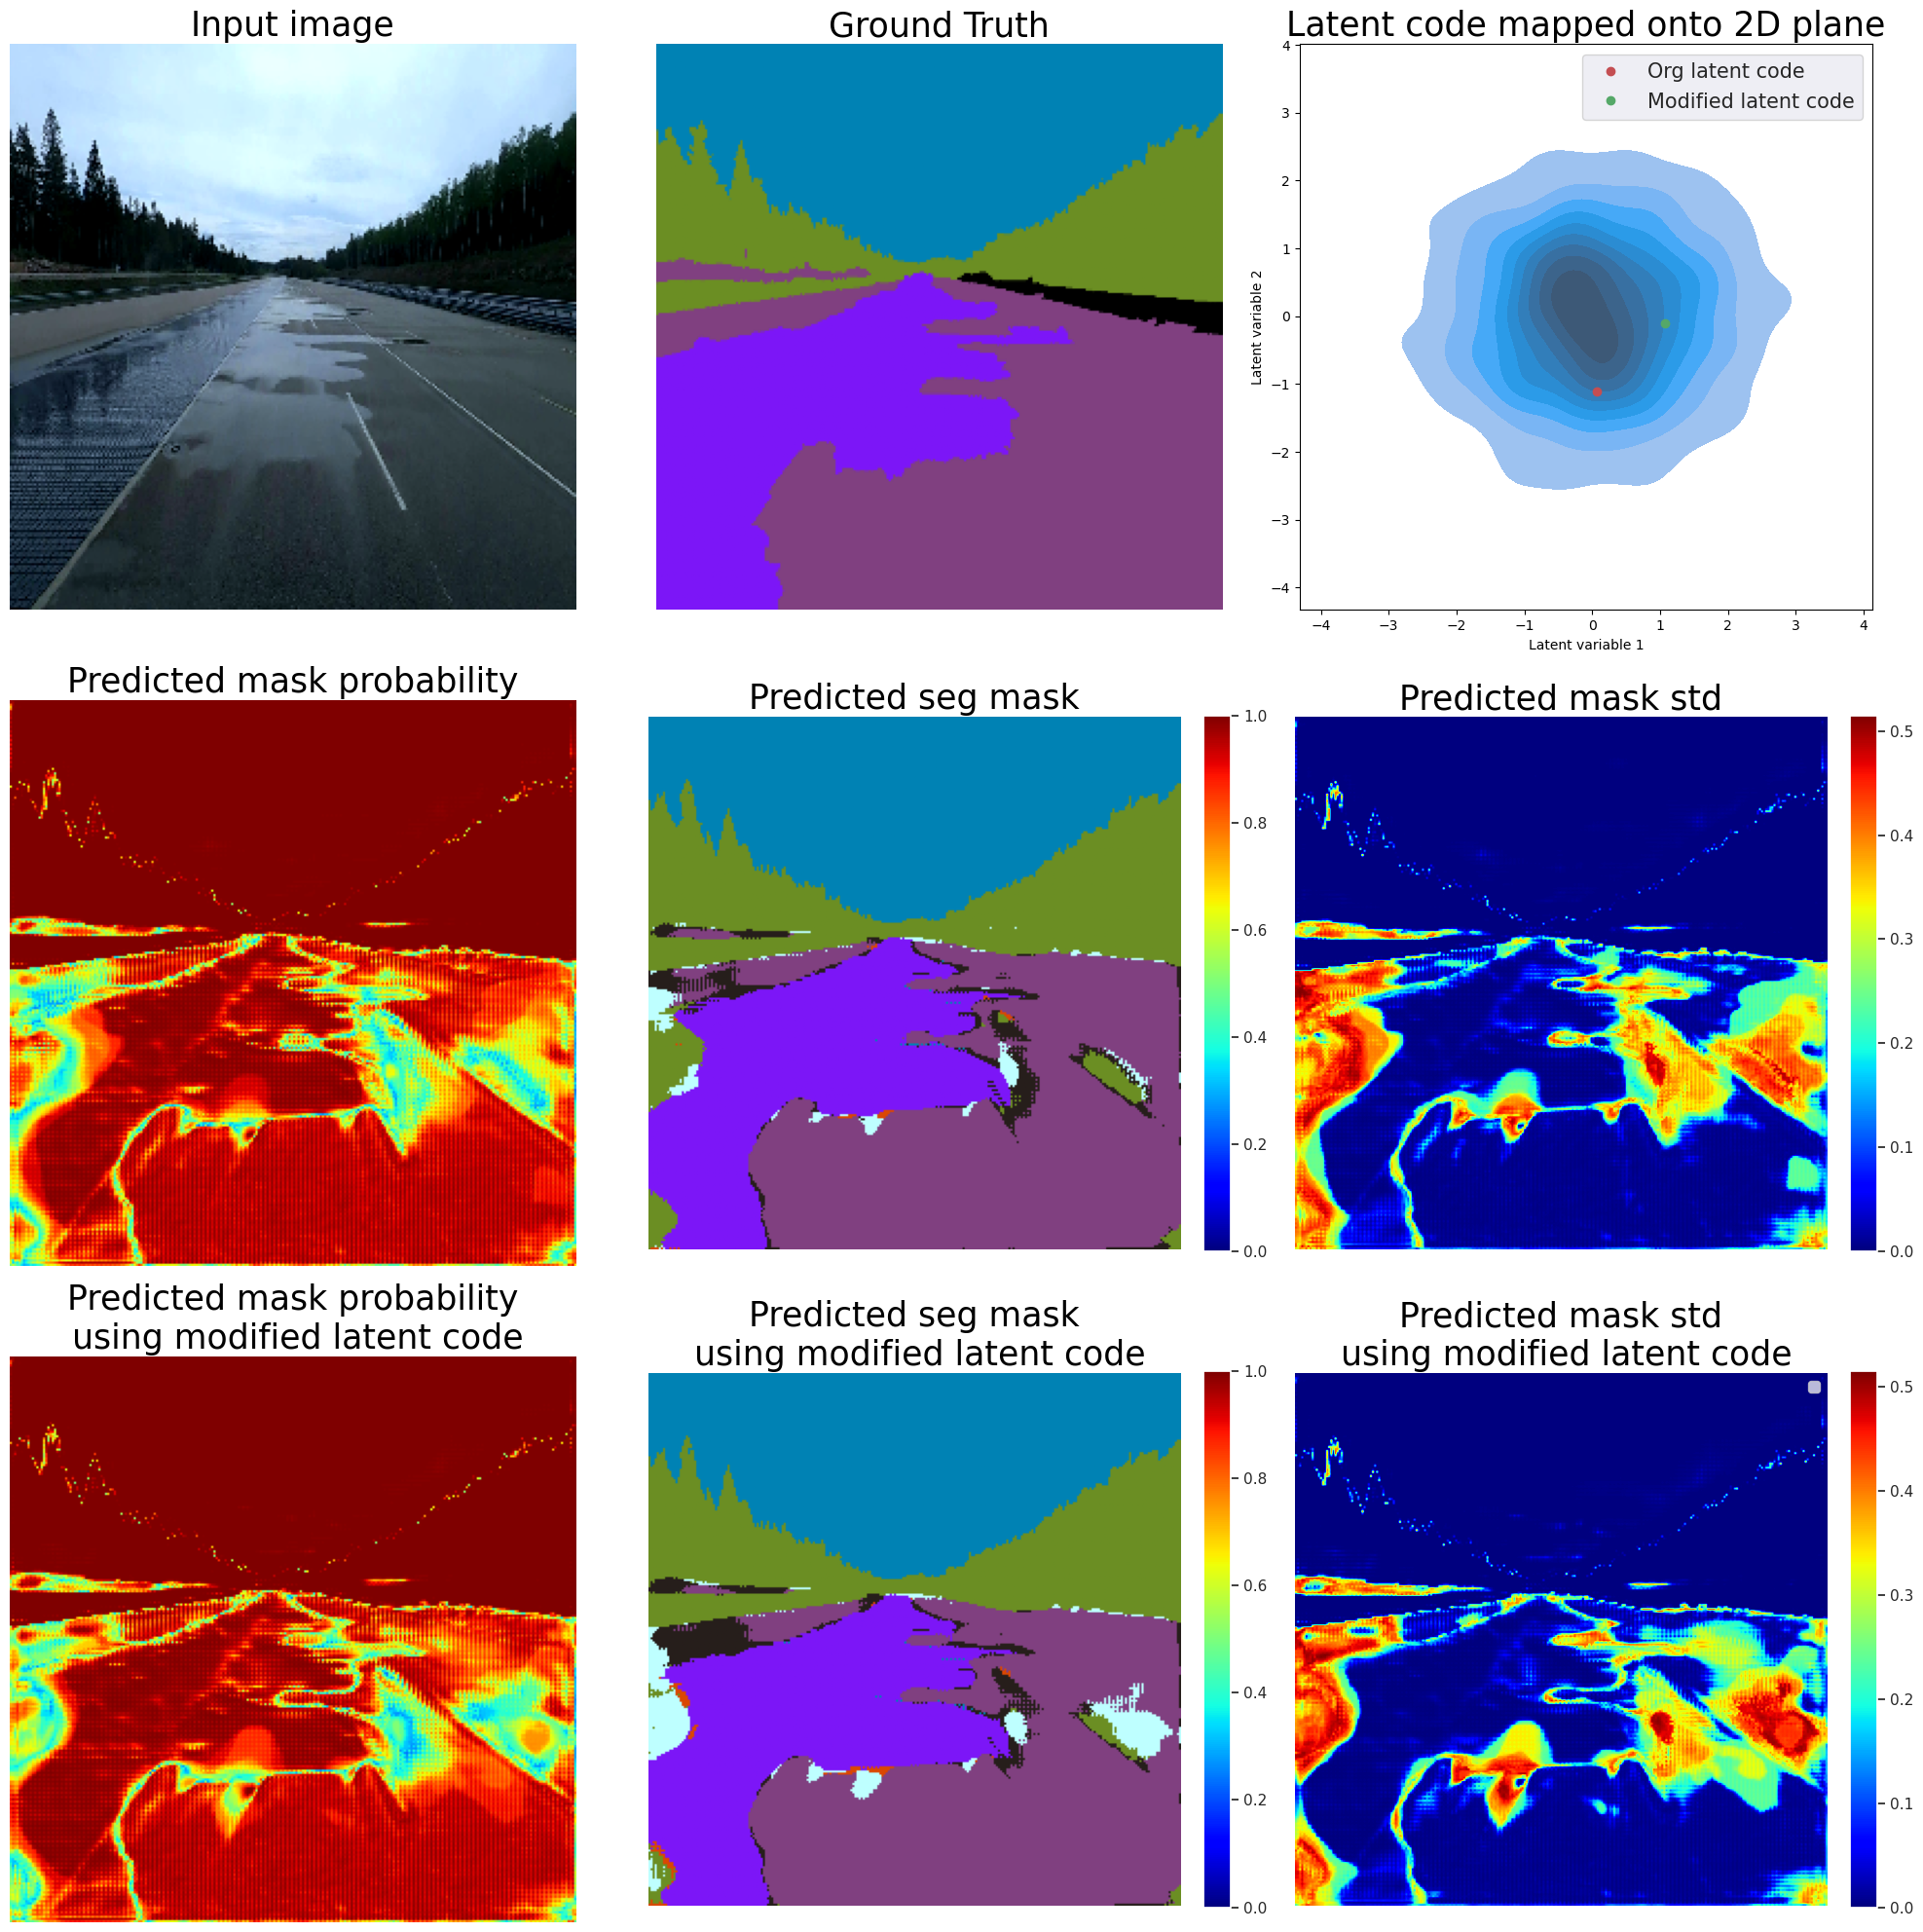

In [10]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(20,20))
input_image = frame["image"].permute(1,2,0).cpu().numpy()
font = 25


ax[0][0].grid(False)
ax[0][1].grid(False)
ax[0][2].grid(False)
ax[1][0].grid(False)
ax[1][1].grid(False)
ax[1][2].grid(False)
ax[2][0].grid(False)
ax[2][1].grid(False)
ax[2][2].grid(False)


ax[0][0].axis("off")
ax[0][1].axis("off")
# ax[0][2].grid("off")
ax[1][0].axis("off")
ax[1][1].axis("off")
ax[1][2].axis("off")
ax[2][0].axis("off")
ax[2][1].axis("off")
ax[2][2].axis("off")

ax[0][1].imshow(frame["seg"].permute(1, 2, 0))
ax[0][1].set_title("Ground Truth", fontsize=font)

ax[0][0].imshow(invTrans(frame["image"].cpu()).permute(1, 2, 0))
ax[0][0].set_title("Input image", fontsize=font)

sns.kdeplot(data=sampledDF, x="Latent variable 1", y="Latent variable 2", ax = ax[0][2], fill = True)
sns.set(rc={"figure.figsize":(20, 20)})
ax[0][2].plot(sample_transformed[0][0], sample_transformed[0][1], "ro", label = "Org latent code")
ax[0][2].plot(sample_transformed_modified[0][0], sample_transformed_modified[0][1], "go", label = "Modified latent code")
ax[0][2].set_aspect(1)
ax[0][2].legend(loc="upper right", prop={'size': 15})
ax[0][2].set_title("Latent code mapped onto 2D plane", fontsize=font)


segs, dists, _ = model.latentVisualize(frame["image"].unsqueeze(0).to(device), sampleLatent1 = sample, sampleLatent2 = None, sampleLatent3 = None)
seg = torch.mean(segs, 0).squeeze().cpu()
seg_std = torch.std(segs,0).squeeze(0).cpu()
seg_mask = torch.max(seg,0)[0].cpu().detach().numpy()


ax[1][1].set_title("Predicted seg mask", fontsize=font)
ax[1][1].imshow(dataloader.prMask_to_color(seg.unsqueeze(0)).squeeze().permute(1,2,0))


cmap = plt.get_cmap('jet')
heatmap_seg = cmap(seg_mask)[:,:,:3]
alpha = 1
output_seg = (1 - alpha) * input_image + alpha * heatmap_seg
output_seg = torch.clamp(torch.tensor(output_seg), 0, 1)
im = ax[1][0].imshow(output_seg.cpu().numpy(), cmap = cmap, vmin=output_seg.min(), vmax=output_seg.max())
ax[1][0].set_title("Predicted mask probability", fontsize=font)
cbar = fig.colorbar(im, ax=ax[1][1], fraction=0.046, pad=0.04)


#seg var heatmap
_, idx = torch.max(seg,0)
MaxClassVar = torch.zeros_like(idx).float()
for i in range(idx.shape[0]):
    for j in range(idx.shape[1]):
        MaxClassVar[i,j] = seg_std[idx[i,j],i,j]

cmap = plt.get_cmap('jet')
im = ax[1][2].imshow(MaxClassVar.detach().numpy(), cmap = cmap, vmin=MaxClassVar.min(), vmax=MaxClassVar.max())
ax[1][2].set_title("Predicted mask std", fontsize=font)
cbar = fig.colorbar(im, ax=ax[1][2], fraction=0.046, pad=0.04)




segs, dists, _ = model.latentVisualize(frame["image"].unsqueeze(0).to(device), sampleLatent1 = sample_modified, sampleLatent2 = None, sampleLatent3 = None)
seg = torch.mean(segs, 0).squeeze().cpu()
seg_std = torch.std(segs,0).squeeze(0).cpu()
seg_mask = torch.max(seg,0)[0].cpu().detach().numpy()


ax[2][1].set_title("Predicted seg mask\n using modified latent code", fontsize=font)
ax[2][1].imshow(dataloader.prMask_to_color(seg.unsqueeze(0)).squeeze().permute(1,2,0))


cmap = plt.get_cmap('jet')
heatmap_seg = cmap(seg_mask)[:,:,:3]
alpha = 1
output_seg = (1 - alpha) * input_image + alpha * heatmap_seg
output_seg = torch.clamp(torch.tensor(output_seg), 0, 1)
im = ax[2][0].imshow(output_seg.cpu().numpy(), cmap = cmap, vmin=output_seg.min(), vmax=output_seg.max())
ax[2][0].set_title("Predicted mask probability\n using modified latent code", fontsize=font)
cbar = fig.colorbar(im, ax=ax[2][1], fraction=0.046, pad=0.04)


#seg var heatmap
_, idx = torch.max(seg,0)
MaxClassVar = torch.zeros_like(idx).float()
for i in range(idx.shape[0]):
    for j in range(idx.shape[1]):
        MaxClassVar[i,j] = seg_std[idx[i,j],i,j]

cmap = plt.get_cmap('jet')
im = ax[2][2].imshow(MaxClassVar.detach().numpy(), cmap = cmap, vmin=MaxClassVar.min(), vmax=MaxClassVar.max())
ax[2][2].set_title("Predicted mask std\n using modified latent code", fontsize=font)
cbar = fig.colorbar(im, ax=ax[2][2], fraction=0.046, pad=0.04)



fig.tight_layout()
plt.legend()
plt.savefig('probMask.png', transparent=True)
# plt.show()
# plt.savefig('probMaskLatent.png')